In [1]:
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np   
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

In [3]:
train_df = pd.read_csv('../House Prices/train.csv')

In [4]:
train_df.SalePrice = np.log1p(train_df.SalePrice)

In [5]:
train_df.shape

(1460, 81)

## Визуализация данных

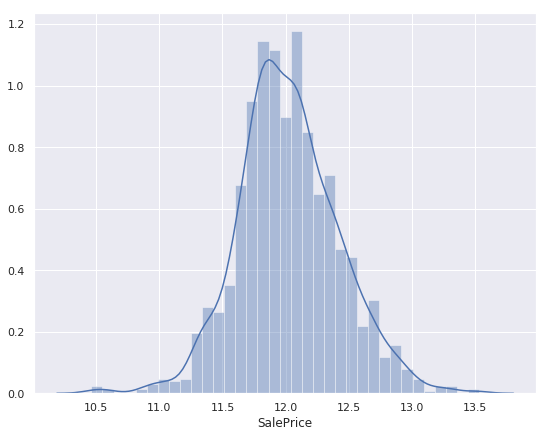

In [6]:
# Распределение целевой переменной
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train_df['SalePrice']);

In [7]:
target_scaled = StandardScaler().fit_transform(train_df[['SalePrice']])
train_df['SalePrice'] = target_scaled

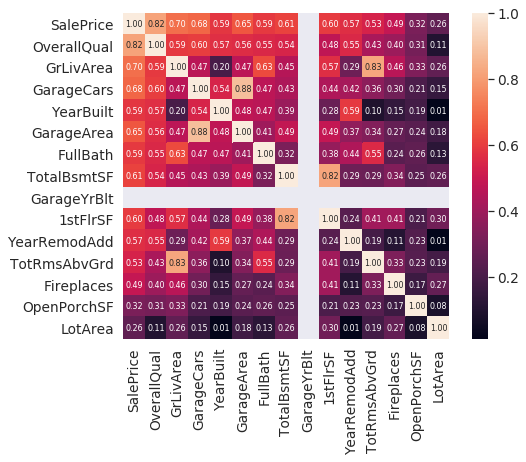

In [8]:
k = 15
corrmat = abs(train_df.corr(method='spearman'))
cols = corrmat.nlargest(k, 'SalePrice').index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

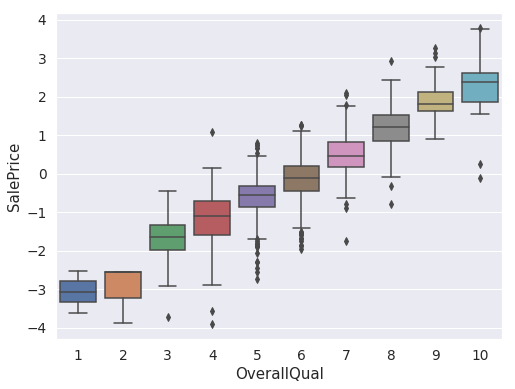

In [9]:
data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)

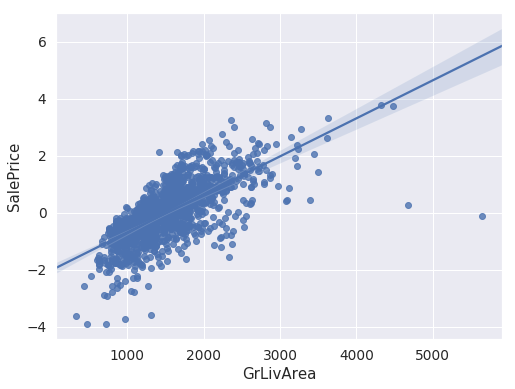

In [10]:
data = pd.concat([train_df['SalePrice'], train_df['GrLivArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='GrLivArea', y="SalePrice", data=data)

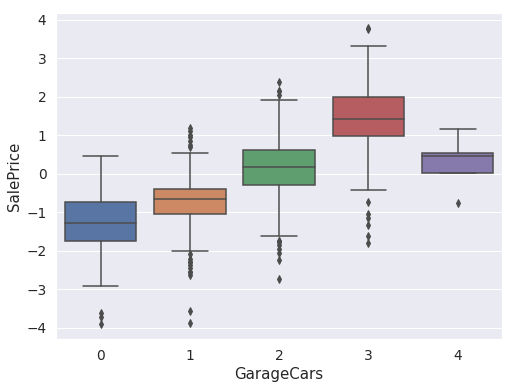

In [11]:
data = pd.concat([train_df['SalePrice'], train_df['GarageCars']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=data)

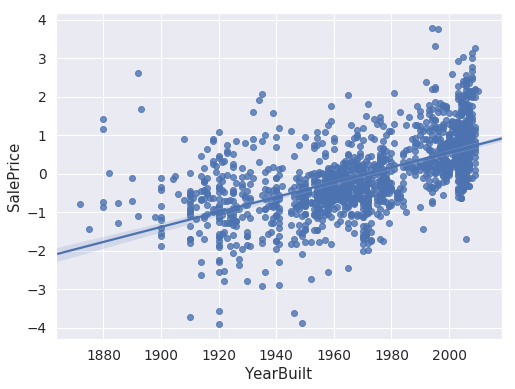

In [12]:
data = pd.concat([train_df['SalePrice'], train_df['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='YearBuilt', y="SalePrice", data=data)

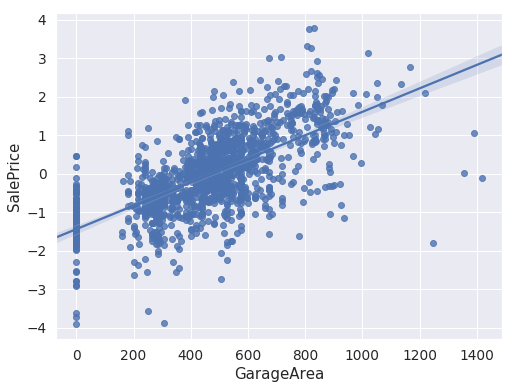

In [13]:
data = pd.concat([train_df['SalePrice'], train_df['GarageArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='GarageArea', y="SalePrice", data=data)

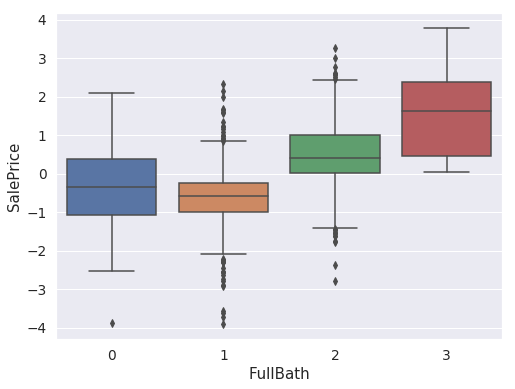

In [14]:
data = pd.concat([train_df['SalePrice'], train_df['FullBath']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='FullBath', y="SalePrice", data=data)

# Drop outliers

In [15]:
train_df.drop(train_df[(train_df.GrLivArea > 4000) & (train_df.SalePrice < 12.5)].index, inplace=True)
train_df = train_df.drop(train_df[(train_df['LotArea']>150000)].index)
train_df = train_df.drop(train_df[(train_df['GarageArea']>1200) & (train_df['SalePrice']<12.5)].index)

# Нахождение и заполнение пропущенных значений


In [16]:
def find_missing_values(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = 100 * (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    graph = percent[:20].plot(kind='bar', figsize=(8,6), fontsize=10)
    plt.xlabel("Columns", fontsize = 20)
    plt.ylabel("Percentage", fontsize = 20)
    plt.title("Total Missing Value (%)", fontsize = 20)
    return missing_data.head(), graph 

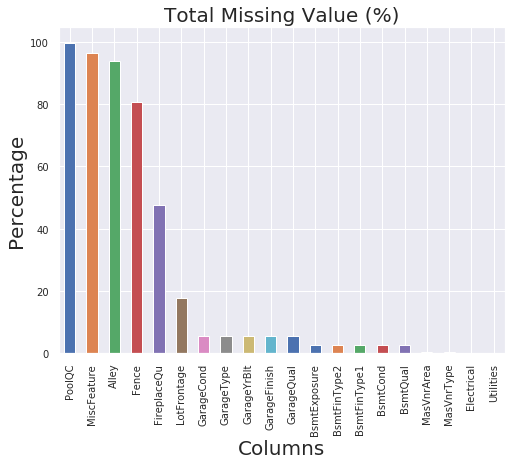

In [17]:
find_missing_values(train_df);

In [18]:
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Utilities']
train_df.drop(cols_to_drop, axis=1, inplace=True)

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train_df[col] = train_df[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train_df[col] = train_df[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train_df[col] = train_df[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_df[col] = train_df[col].fillna('None')
    
train_df["MasVnrType"] = train_df["MasVnrType"].fillna("None")
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(0)

train_df['MSSubClass'] = train_df['MSSubClass'].fillna("None")
train_df["Functional"] = train_df["Functional"].fillna("Typ")

train_df['MSZoning'] = train_df['MSZoning'].fillna(train_df['MSZoning'].mode()[0])
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
train_df['KitchenQual'] = train_df['KitchenQual'].fillna(train_df['KitchenQual'].mode()[0])
train_df['Exterior1st'] = train_df['Exterior1st'].fillna(train_df['Exterior1st'].mode()[0])
train_df['Exterior2nd'] = train_df['Exterior2nd'].fillna(train_df['Exterior2nd'].mode()[0])
train_df['SaleType'] = train_df['SaleType'].fillna(train_df['SaleType'].mode()[0])

train_df['LotFrontage'].fillna(train_df['LotFrontage'].mean(), inplace=True)

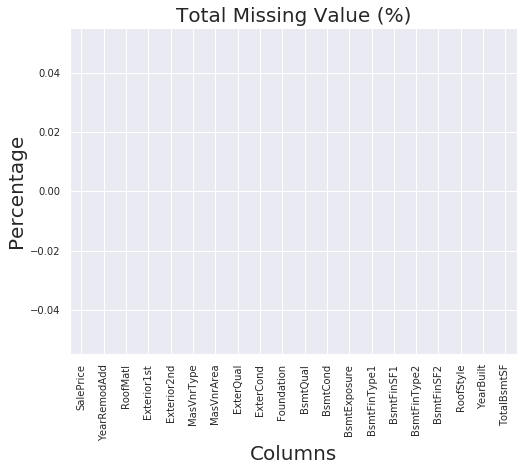

In [19]:
find_missing_values(train_df);

### Dummy variables

In [20]:
train_df = pd.get_dummies(train_df)

In [21]:
train_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [22]:
# Разделяем исходный датасет
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=23)

# kNN

In [23]:
neigh_default = KNeighborsRegressor()
neigh_default.fit(X_train, y_train)
y_pred = neigh_default.predict(X_valid)
print(f'MSE of default kNN is {mean_squared_error(y_valid, y_pred)}')

MSE of default kNN is 0.30093114960774325


In [24]:
# Tuning k values and weights
params = {
    'n_neighbors': np.arange(1, 11),
    'weights': ['uniform', 'distance'] # uniform - все точки в каждой окрестности взвешены одинаково; 
                                       # distance - присваемый вес точки зависит от расстояния до нее
}

In [25]:
grid = GridSearchCV(neigh_default, param_grid=params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [26]:
grid.best_params_, -grid.best_score_

({'n_neighbors': 7, 'weights': 'distance'}, 0.35936698327481287)

In [27]:
neigh_best = grid.best_estimator_
print(f'MSE of tuned knn: {mean_squared_error(y_valid, neigh_best.predict(X_valid))}')

MSE of tuned knn: 0.28791343950111137


# Linear Regression

In [28]:
reg = LinearRegression().fit(X_train, y_train)

In [29]:
reg.coef_[:10]

array([-1.11389821e-05,  5.07768162e-05,  1.48376036e-04,  1.27024840e-05,
        9.59418029e-02,  1.03440211e-01,  3.95120135e-03,  2.28608022e-03,
        6.91121660e-05,  1.45151029e-04])

In [30]:
reg.intercept_

-5.584429940332859

In [31]:
y_valid_pred = reg.predict(X_valid)

In [32]:
#Validation score
print("MSE: %.2f" \
      % mean_squared_error(y_valid, y_valid_pred))

MSE: 0.08


# Ridge Regression

In [33]:
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001])

In [34]:
model = Ridge()

In [35]:
tuning = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [36]:
tuning.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [37]:
tuning.best_params_, -tuning.best_score_

({'alpha': 1.0}, 0.098829068058627)

In [38]:
tuning_best = tuning.best_estimator_
print(f'MSE of tuned Ridge regression: {mean_squared_error(y_valid, tuning_best.predict(X_valid))}')

MSE of tuned Ridge regression: 0.07140576355377594


# Lasso Regression

In [39]:
model = Lasso()

In [40]:
tuning = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [41]:
tuning.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [42]:
tuning.best_params_, -tuning.best_score_

({'alpha': 0.001}, 0.0874995469409859)

In [43]:
tuning_best = tuning.best_estimator_
print(f'MSE of tuned Lasso regression: {mean_squared_error(y_valid, tuning_best.predict(X_valid))}')

MSE of tuned Lasso regression: 0.0660981050355785


# Decision Tree

In [52]:
# Дерево без тюнинга хайперпараметров
tree1 = DecisionTreeRegressor(random_state=23).fit(X_train, y_train)
y_pred_1 = tree1.predict(X_valid)
print(f'Score of DecisionTree(MSE): {mean_squared_error(y_valid, y_pred_1)}')

Score of DecisionTree(MSE): 0.28989009167829294


In [53]:
# Дерево после тюнинга хайперпараметров
tree2 = DecisionTreeRegressor(random_state=23)
tree_params = {'max_depth': list(range(1, 11)), \
               'min_samples_split': np.linspace(0.1, 1.0, 10), \
               'min_samples_leaf': np.linspace(0.1, 0.5, 5)
              }
tree_grid = GridSearchCV(tree2, tree_params, cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=23, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
tree_grid.best_params_

{'max_depth': 4, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}

In [55]:
tree2 = tree_grid.best_estimator_
y_pred_2 = tree2.predict(X_valid)
print(f'Score of DecisionTree(MSE): {mean_squared_error(y_valid, y_pred_2)}')

Score of DecisionTree(MSE): 0.2842303569262459


# Random Forest

In [56]:
def print_score(rf):
    res = [mean_squared_error(rf.predict(X_train), y_train), mean_squared_error(rf.predict(X_valid), y_valid),
           rf.score(X_train, y_train), rf.score(X_valid, y_valid)]
    if hasattr(rf, 'oob_score_'): res.append(rf.oob_score_)
    print(res)
    
def plot_fi(fi):
    return fi.sort_values("importance", ascending=False)[:25].plot('feature', 'importance', 'barh', figsize=(12, 7), legend=False)

In [57]:
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True, random_state=23)

In [58]:
%%time
rf.fit(X_train, y_train)

CPU times: user 3.13 s, sys: 212 ms, total: 3.35 s
Wall time: 1.88 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=23, verbose=0, warm_start=False)

In [59]:
print_score(rf)

[0.03636443057305266, 0.10698748093723921, 0.9636797881274334, 0.8829730602006045, 0.857781561227534]


In [60]:
# Feature importance
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.round(rf.feature_importances_, 3)
})

In [61]:
importances.sort_values("importance", ascending=False)[:10]

,feature,importance
4,OverallQual,0.589
16,GrLivArea,0.105
13,1stFlrSF,0.037
12,TotalBsmtSF,0.037
27,GarageArea,0.030
9,BsmtFinSF1,0.017
26,GarageCars,0.015
25,GarageYrBlt,0.014
6,YearBuilt,0.012
7,YearRemodAdd,0.012


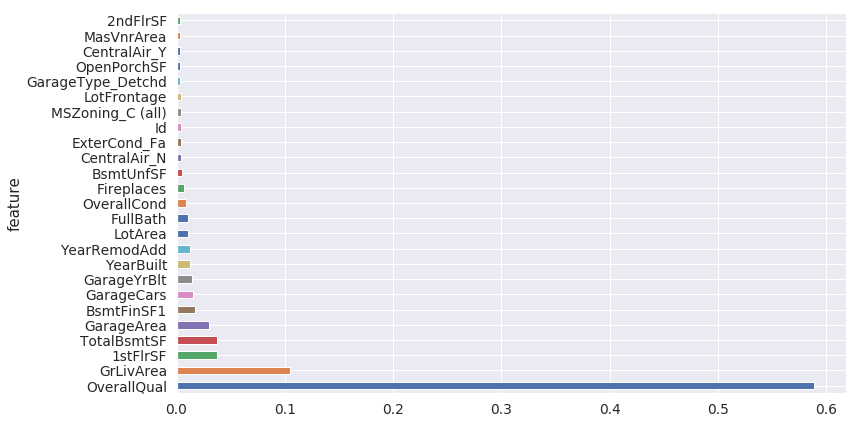

In [62]:
plot_fi(importances);

In [63]:
to_keep = importances[importances.importance > 0.002].feature 
len(to_keep)

26

In [64]:
df_keep = train_df[to_keep].copy()
X_train, X_valid = train_test_split(df_keep, test_size=0.3, random_state=23)

In [65]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04156300801135627, 0.10546304977197399, 0.9584875320953796, 0.8846405404762685, 0.867503364128432]


In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=23)

In [67]:
# Hyperparameter tuning and GridSearchCV
param_grid = {
    'max_features': [None, 0.5, 'sqrt'],
    'min_samples_leaf': [1, 3, 5, 10, 25, 100]
}
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=3, n_jobs=-1)

In [68]:
%%time
rf_grid_search.fit(X_train, y_train)

CPU times: user 7.66 s, sys: 1 s, total: 8.67 s
Wall time: 1min 39s


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 0.5, 'sqrt'], 'min_samples_leaf': [1, 3, 5, 10, 25, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
rf_grid_search.best_params_

{'max_features': 0.5, 'min_samples_leaf': 1}

In [70]:
best_est = rf_grid_search.best_estimator_

In [71]:
print_score(best_est)

[0.01659109366419359, 0.09403916766944097, 0.9834290809017191, 0.8971364133707127, 0.8734011109484872]


# Gradient Boosting

In [72]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_leaf': 2, \
         'learning_rate': 0.08, 'loss': 'ls'} #ls =  least squares regression
clf = GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.08, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [73]:
y_pred = clf.predict(X_valid)
print(f'MSE for GradientBoostingRegressor: {mean_squared_error(y_valid, y_pred)}')

MSE for GradientBoostingRegressor: 0.0891212964916545


In [74]:
# GB feature importance
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.round(clf.feature_importances_, 3)
})

In [75]:
importances.sort_values("importance", ascending=False)[:10]

,feature,importance
0,Id,0.070
16,GrLivArea,0.054
3,LotArea,0.045
27,GarageArea,0.044
11,BsmtUnfSF,0.042
4,OverallQual,0.037
6,YearBuilt,0.030
12,TotalBsmtSF,0.028
9,BsmtFinSF1,0.028
13,1stFlrSF,0.026
